<a href="https://colab.research.google.com/github/ronychhagar/reinforcement_learning/blob/main/Fan_speed_update_with_velocity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install 'shimmy>=0.2.1'
!pip install stable-baselines3


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | -4.76    |
| time/              |          |
|    fps             | 1177     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


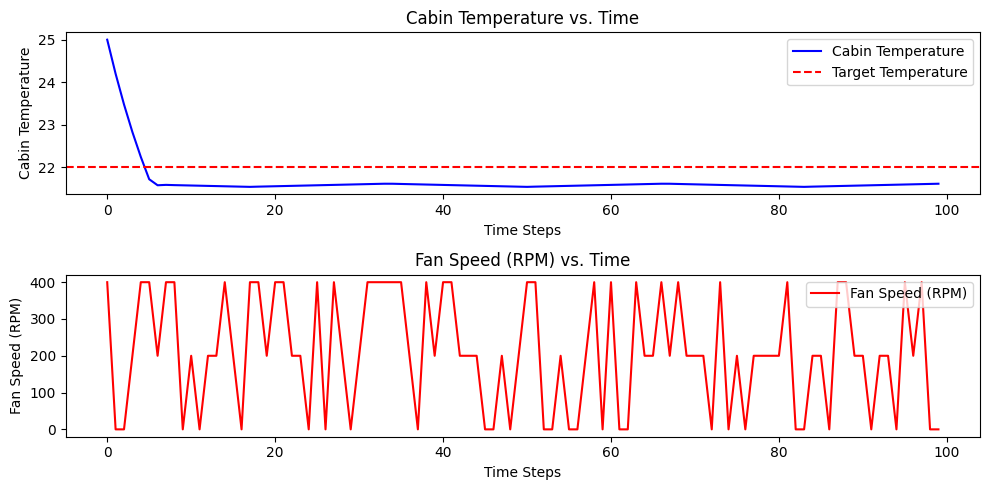

In [16]:
import gym
from stable_baselines3 import PPO
import time
import matplotlib.pyplot as plt
import numpy as np

class ThermalManagementEnv(gym.Env):
    def __init__(self, target_temp, velocity_profile):
        super(ThermalManagementEnv, self).__init__()
        self.target_temp = target_temp
        self.current_temp = 25.0
        self.max_fan_speed_rpm = 2000  # Maximum fan speed in RPM
        self.min_fan_speed_rpm = 0     # Minimum fan speed in RPM
        self.velocity_profile = velocity_profile
        self.action_space = gym.spaces.Discrete(3)  # Fan off, Fan low, Fan high
        self.observation_space = gym.spaces.Box(
            low=0, high=100, shape=(1,), dtype=float
        )
        self.time_step = 0

    def step(self, action):
        fan_action = action
        if fan_action == 0:
            fan_speed_rpm = 0
        elif fan_action == 1:
            fan_speed_rpm = self.max_fan_speed_rpm // 2
        else:
            fan_speed_rpm = self.max_fan_speed_rpm

        if self.time_step < len(self.velocity_profile):
            velocity = self.velocity_profile[self.time_step]
        else:
            velocity = self.velocity_profile[-1]

        heat_loss = (self.current_temp - self.target_temp) * 0.1
        # Adjust fan speed more accurately based on the temperature difference
        fan_speed = (self.target_temp - self.current_temp) * 10 + (velocity / 100)
        fan_speed = min(max(fan_speed, 0), self.max_fan_speed_rpm)  # Ensure fan_speed is within bounds
        self.current_temp += (fan_speed / 10) - 0.5 - heat_loss
        reward = -abs(self.current_temp - self.target_temp)
        done = abs(self.current_temp - self.target_temp) < 0.5
        self.time_step += 1
        return [self.current_temp], reward, done, {}

    def reset(self):
        self.current_temp = 25.0
        self.time_step = 0
        return [self.current_temp]

# Define an extended velocity profile
extended_velocity_profile = [80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
                            80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
                            80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

# Train the model
target_temp = 22.0
env = ThermalManagementEnv(target_temp, extended_velocity_profile)

total_timesteps = len(extended_velocity_profile)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=total_timesteps)
model.save("thermal_management_model")

# Load the trained model
loaded_model = PPO.load("thermal_management_model")

# Simulate and collect results using the extended velocity profile
obs = env.reset()
temps = [obs[0]]
fan_speeds = []

for velocity in extended_velocity_profile:
    action, _ = loaded_model.predict([obs])
    obs, _, done, _ = env.step(action)
    temps.append(obs[0])
    fan_speeds.append(action)

# Append an additional fan speed value to match the dimensions
fan_speeds.append(0)

time_steps = np.arange(len(temps))

# Plot cabin temperature
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(time_steps, temps, label="Cabin Temperature", color='b')
plt.axhline(y=target_temp, color='r', linestyle='--', label="Target Temperature")
plt.xlabel("Time Steps")
plt.ylabel("Cabin Temperature")
plt.title("Cabin Temperature vs. Time")
plt.legend()

# Plot fan speed in RPM
plt.subplot(2, 1, 2)
fan_speeds_rpm = [(speed * (env.max_fan_speed_rpm // 10)) + env.min_fan_speed_rpm for speed in fan_speeds]
plt.plot(time_steps, fan_speeds_rpm, label="Fan Speed (RPM)", color='r')
plt.xlabel("Time Steps")
plt.ylabel("Fan Speed (RPM)")
plt.title("Fan Speed (RPM) vs. Time")
plt.legend()

plt.tight_layout()
plt.show()
